<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraries and Utilities</h3>


In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import networkx          as nx
import seaborn           as sns
from nltk                import ngrams
from pyvis.network       import Network
import os
import re
import nltk
import pydot
import spacy as sp
from wordcloud import WordCloud
from tqdm.notebook import tqdm


nlps = sp.load('en_core_web_sm')

In [2]:
class BiGramGraph:
    """
    A class used to transform a corpus given as a numpy array into a graph form of the
    2-gram representation.

    ...

    Attributes
    ----------
    Graph : nx.Graph
        The Graph Representation of The Ngram Input.
    N_nodes : int
        Number of Nodes in Graph.
    N_edges : int
        Number of Edges in Graph.
    In_Max_Deg : int
        Maximum In Degree in Graph.
    Out_Max_Deg : int
        Maximum Out Degree in Graph.
    In_Min_Deg : int
        Minimum In Degree in Graph.
    Out_Min_Deg : int
        Minimum Out Degree in Graph.

    Methods
    -------
    Example_Method(arg=None)
        Add info
    """

    def __init__(self, data, notebook=False):
        if not notebook:
            from tqdm import tqdm
            tqdm.pandas()
        else:
            from tqdm.notebook import tqdm
            tqdm.pandas()

        n = 2
        tokenized_text = ' '.join(data).split()
        ngram = ngrams(tokenized_text, n=n)
        ngram = list(ngram)

        n_frequencies = nltk.FreqDist(ngram)
        edges = list(dict(n_frequencies).keys())
        nodes = np.unique(np.array(edges).flatten())
        self.Graph = nx.DiGraph()
        self.Graph.add_nodes_from(nodes)
        for x, y in edges:
            self.Graph.add_edge(x, y, value=n_frequencies[(x, y)])

            # Graph Attributes
        self.N_nodes = len(nodes)
        self.N_edges = len(edges)
        self.In_Max_Deg = max(dict(self.Graph.in_degree).values())
        self.Out_Max_Deg = max(dict(self.Graph.out_degree).values())
        self.In_Min_Deg = min(dict(self.Graph.in_degree).values())
        self.Out_Min_Deg = min(dict(self.Graph.out_degree).values())
        self._nlp = None
        self.Data = nx.algorithms.coloring.greedy_color(self.Graph)
        self.Data = pd.DataFrame([self.Data.values(),
                                  self.Data.keys()]).T.rename(columns={0: 'color', 1: 'word'})

        self.Edges = pd.DataFrame(edges, columns=['in', 'out'])
        self.Edges['weight'] = self.Edges.apply(lambda _z: n_frequencies[(_z['in'], _z['out'])], axis=1)

    def add_part_of_speech(self):
        import spacy as sp
        self._nlp = sp.load('en_core_web_sm')
        self.Data['pos'] = self.Data['word'].progress_apply(lambda _z: self._nlp(str(_z))[0].pos_)

    def get_Xi(self) -> int:
        """
        :return: The chromatic number of the graph.
        """
        return self.Data['color'].max() + 1
    
    def is_DAG(self):
        return nx.algorithms.dag.is_directed_acyclic_graph(self.Graph)
    def get_Diameter(self):
        return nx.algorithms.distance_measures.diameter(self.Graph)
    
    def get_Min_Edge_Cover(self):
        return nx.algorithms.covering.min_edge_cover(self.Graph)
    
    def get_Shortest_Simple_Path(self,start_node,end_node):
        return nx.algorithms.simple_paths.shortest_simple_paths(self.Graph,source=start_node,target=end_node)
    
    def get_Eulerian(self):
        if nx.is_eulerian(self.Graph):
            return nx.eulerian_circuit()(self.Graph)
        else:
            return 'Not Eulerian'
        
    def get_Volume(self,S):
        return nx.algorithms.cuts.volume(self.Graph,S)
        
    def get_Eulerian_Path(self):
        return nx.eulerian_path(self.Graph) if nx.has_eulerian_path(self.Graph) else "Graph Has No Eulerian Path"
        
    def get_Cycle(self,start_node):
        return nx.algorithms.cycles.find_cycle(self.Graph,start_node)
    
    def get_All_Unique_Cycles(self):
        hash_list = []
        unique_cycle = []
        for i in tqdm(range(11857)):
            cyclye = self.get_Cycle(Bigraph.Data.word[i])
            c_hash = hash(str(self.get_Cycle(self.Data.word[i])))
            if c_hash not in hash_list:
                hash_list.append(c_hash)
                unique_cycle.append(cyclye)
        return unique_cycle
    def get_All_Simple_Cycles(self):
        return nx.algorithms.cycles.simple_cycles(self.Graph)
    
    def is_Strongly_Connected(self):
        return nx.algorithms.components.is_strongly_connected(self.Graph)
    def get_Number_Strongly_Connected_Components(self):
        return nx.algorithms.components.number_strongly_connected_components(self.Graph)
    def get_Strongly_Connected_Components(self):
        return nx.algorithms.components.strongly_connected_components(self.Graph)
            

    def __repr__(self):
        n = self.N_nodes
        e = self.N_edges
        xi = self.get_Xi()
        return f'Number of words included: {n}\nNumber of edges included: {e}\nChromatic number: {xi}\n'

    def __getitem__(self, item) -> dict:
        return dict()

    def vectorize(self, string, method='chromatic'):
        if method == 'chromatic':
            tokens = string.split(' ')
            vec_form = []
            for tok in tokens:
                if tok not in self.Data.word.values:
                    continue
                vec_form.append(self.Data.query(f'word == "{tok}"')['color'].values[0])
            return vec_form
        else:
            raise NameError('Bad Method')

    def Viz_Graph(self, notebook=False, height=500, width=900, directed=False):
        nt = Network(f'{height}px', f'{width}px', notebook=notebook, directed=directed)
        nt.set_options(
            'var options = { "physics": {"forceAtlas2Based": {"gravitationalConstant": -230,"springLength": 170,\
              "springConstant": 0,\
              "avoidOverlap": 1\
            },\
            "minVelocity": 0.75,\
            "solver": "forceAtlas2Based",\
            "timestep": 1\
          }\
        }\
        ')
        nt.from_nx(self.Graph)
        # nt.show_buttons(filter_=['physics'])
        nt.prep_notebook()
        return nt.show('nx.html')


In [40]:
#Utils

def calculate_path_weight(Graph,path):
    weight = 0
    start = path[0]
    for i in path[1:]:
        weight += Graph.Edges[(Graph.Edges['in'] == start[0])&(Graph.Edges.out == i[0])].weight.values[0]
        start =i
    return weight

def calculate_cycle_density(Graph,cycle):
    weight = 0
    for i in cycle:
        weight += np.sqrt(Graph.Graph.out_degree(i[0])+Graph.Graph.in_degree(i[0]))
    return weight    

def calculate_path_density(Graph,path):
    weight = 0
    for i in path:
        IN  = Graph.Graph.out_degree(i[0])
        OUT = Graph.Graph.in_degree(i[0])
        if type(IN)!=int:
            weight += np.sqrt(OUT)
        elif type(OUT) != int:
            weight += np.sqrt(IN)
        else:
            weight+= np.sqrt(IN+OUT)
    return weight 
    

<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Graph Attribute Exploration</h3>


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Chromatic Number</h3>


 
<h3 style="background-color:green;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Lyrics Dataset</h3>


In [5]:
from wordcloud import STOPWORDS
from string import punctuation
punctuation = punctuation + '“’‛‘”‹›»«–—'
example_corpus = pd.read_csv('LYRICS_DATASET.csv')['Lyrics'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)

C:\Users\tomas\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
print("Chromatic Number of G ",Bigraph.get_Xi())

Chromatic Number of G  12


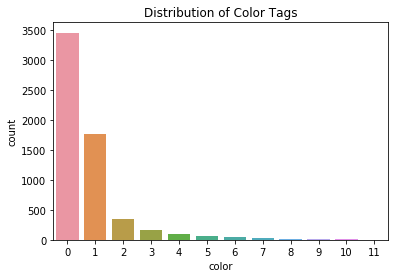

In [7]:
plt.title('Distribution of Color Tags')
sns.countplot(x=Bigraph.Data.color)
plt.show()

In [7]:
'''
Question 1) Are there any connections between low count colors
Question 2) Low dimnesion representation of chromatic vector
Question 3) Is there any connection between part of speech and chromatic number
Question 4) 
'''

'\nQuestion 1) Are there any connections between low count colors\nQuestion 2) Low dimnesion representation of chromatic vector\nQuestion 3) Is there any connection between part of speech and chromatic number\nQuestion 4) \n'

In [8]:
Bigraph.add_part_of_speech()

In [9]:
threshold = np.round(Bigraph.Data.color.value_counts().max()*0.2)
color_counts = Bigraph.Data.color.value_counts()
rare_color_counts = color_counts[color_counts<threshold]
common_color_counts = color_counts[color_counts>threshold]

query = ' '.join(f'color == {i} or' for i in rare_color_counts.index)
query = query[:-3]
rare_under_testing = Bigraph.Data.query(query)
rare_under_testing

query = ' '.join(f'color == {i} or' for i in common_color_counts.index)
query = query[:-3]
common_under_testing = Bigraph.Data.query(query)
common_under_testing

,color,word,pos
0,0,i,PRON
1,1,and,CCONJ
2,1,im,PRON
7,0,the,DET
13,1,ill,PROPN
...,...,...,...
5979,1,¡wuh,PROPN
5980,0,£2,SYM
5981,0,ﬁnance,PROPN
5982,0,ﬁnd,PROPN


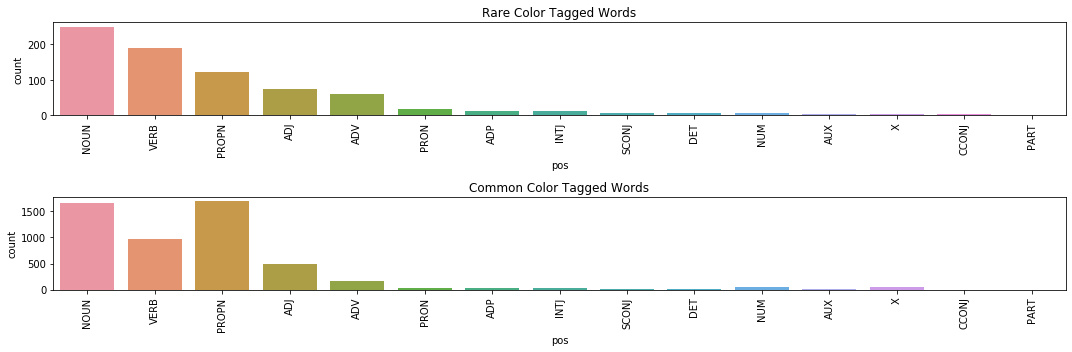

In [312]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.title('Rare Color Tagged Words')
ax=sns.countplot(rare_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.subplot(2,1,2)
plt.title('Common Color Tagged Words')
ax=sns.countplot(common_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.show()

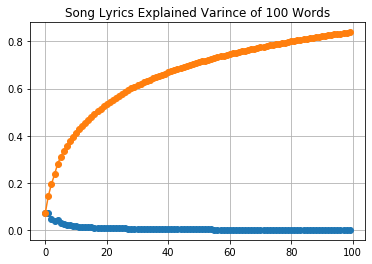

In [10]:
# Claculating Text Variance
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

N = 100
CV=CountVectorizer()
pca = TruncatedSVD(N)
pca.fit(CV.fit_transform(example_corpus).todense())

explained_var = pca.explained_variance_ratio_

plt.title(f'Song Lyrics Explained Varince of {N} Words')
plt.plot(range(N),explained_var,'o-')
plt.plot(range(N),np.cumsum(explained_var),'o-')
plt.grid()

In [11]:
#Vectorizing 
vectorized = []
for i in tqdm(example_corpus):
    vectorized.append(Bigraph.vectorize(i))


KeyboardInterrupt: 

In [ ]:
pad_size = example_corpus.apply(lambda x: len(x)).max()
vec_norm = []
for vec in vectorized:
    V = np.zeros(pad_size)-1
    V[:len(vec)] = vec
    vec_norm.append(np.array(V))
vec_norm = np.array(vec_norm)    

In [381]:
from scipy.spatial import distance_matrix

dm = distance_matrix(vec_norm,vec_norm)

In [411]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=2,metric='cosine')

NN.fit(vec_norm)
distances, indices = NN.kneighbors(vec_norm)
NN

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=1.0)

In [412]:
#intersection between NN
for x,y in indices[:5]:
    INSC = set(example_corpus[x].split()) & set(example_corpus[y].split())
    print((INSC))

{'if', 'but', 'i', 'said', 'see', 'you', 'one', 'go', 'hard', 'never', 'and', 'youre', 'know', 'let', 'time', 'little', 'want', 'im'}
{'every', 'i', 'when', 'house', 'know', 'ive', 'im'}
{'me', 'i', 'one', 'will', 'breathe', 'take'}
{'got', 'but', 'i', 'you', 'they', 'ive', 'im'}
{'i', 'ill', 'and', 'twice', 'man', 'say', 'im'}


In [414]:
#Cosine Distance
from scipy.spatial.distance import cosine
for x,y in indices[:5]:
    INSC = cosine(vec_norm[x,:],vec_norm[y,:])
    print((INSC))

0.1620244605095864
0.10561753940748986
0.11022158021219375
0.11995147813584017
0.13818627546528006


<h3 style="background-color:green;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Amazon Costume Reviews Dataset</h3>


In [107]:
example_corpus = pd.read_csv('Costumes_Amazon.csv')['text'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)

In [416]:
Bigraph

Number of words included: 11857
Number of edges included: 98564
Chromatic number: 23

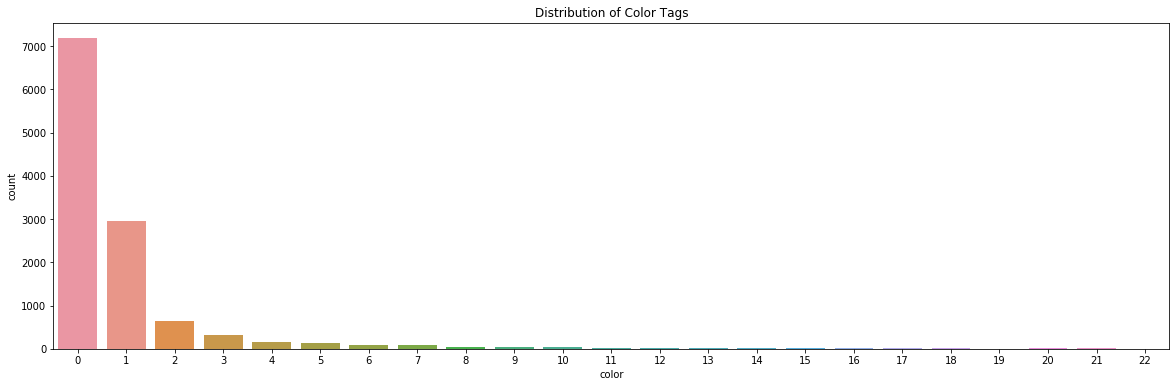

In [417]:
plt.figure(figsize=(20,6))
plt.title('Distribution of Color Tags')
sns.countplot(Bigraph.Data.color)
plt.show()

In [418]:
Bigraph.add_part_of_speech()

In [419]:
threshold = np.round(Bigraph.Data.color.value_counts().max()*0.2)
color_counts = Bigraph.Data.color.value_counts()
rare_color_counts = color_counts[color_counts<threshold]
common_color_counts = color_counts[color_counts>threshold]

query = ' '.join(f'color == {i} or' for i in rare_color_counts.index)
query = query[:-3]
rare_under_testing = Bigraph.Data.query(query)
rare_under_testing

query = ' '.join(f'color == {i} or' for i in common_color_counts.index)
query = query[:-3]
common_under_testing = Bigraph.Data.query(query)
common_under_testing

,color,word,pos
0,0,i,PRON
1,1,costume,NOUN
3,0,the,DET
12,0,my,DET
15,1,im,PRON
...,...,...,...
11852,1,🤪,PROPN
11853,1,🤭,PROPN
11854,0,🤯,X
11855,0,🤷🏼‍♀️,X


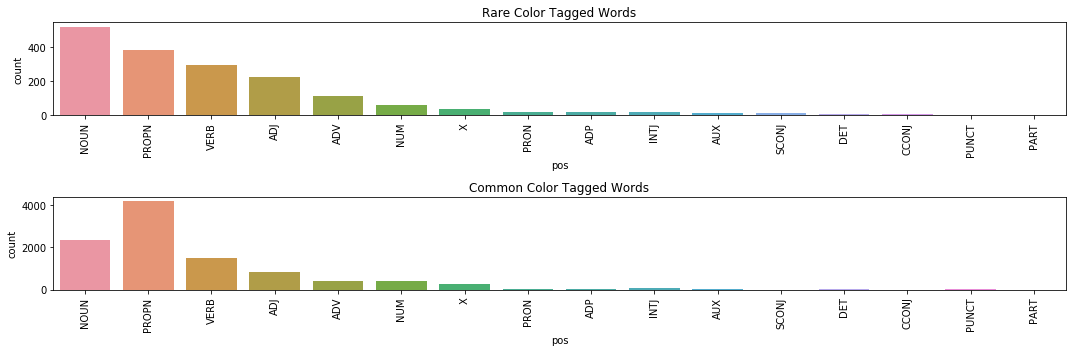

In [420]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.title('Rare Color Tagged Words')
ax=sns.countplot(rare_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.subplot(2,1,2)
plt.title('Common Color Tagged Words')
ax=sns.countplot(common_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.show()

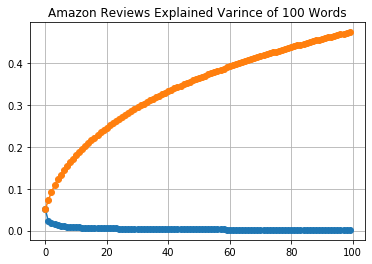

In [421]:
#Testing intext Variance

N = 100
CV=CountVectorizer()
pca = TruncatedSVD(N)
pca.fit(CV.fit_transform(example_corpus))

explained_var = pca.explained_variance_ratio_

plt.title(f'Amazon Reviews Explained Varince of {N} Words')
plt.plot(range(N),explained_var,'o-')
plt.plot(range(N),np.cumsum(explained_var),'o-')
plt.grid()

In [422]:
#Vectorizing 
vectorized = []
for i in tqdm(example_corpus):
    vectorized.append(Bigraph.vectorize(i))


In [426]:
pad_size = example_corpus.apply(lambda x: len(x)).max()
vec_norm = []
for vec in tqdm(vectorized):
    V = np.zeros(pad_size)-1
    V[:len(vec)] = vec
    vec_norm.append(np.array(V))
vec_norm = np.array(vec_norm)    

In [428]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=2,metric='cosine')

NN.fit(vec_norm)
distances, indices = NN.kneighbors(vec_norm)
NN

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=1.0)

In [435]:
#intersection between NN
for x,y in indices[:5]:
    INSC = set(example_corpus[x].split()) & set(example_corpus[y].split())
    print((INSC))

{'wear', 'definitely'}
{'got'}
{'one'}
{'many', 'got', 'compliments', 'costume'}
set()


In [430]:
#Cosine Distance
from scipy.spatial.distance import cosine
for x,y in indices[:5]:
    INSC = cosine(vec_norm[x,:],vec_norm[y,:])
    print((INSC))

0.08873569011914895
0.1478773029739181
0.006708374508506254
0.009145326607094995
0.0530115020311005


<h3 style="background-color:green;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Computer Science Book Description Dataset</h3>


In [436]:
example_corpus = pd.read_csv('prog_book.csv')['Description'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)

C:\Users\tomas\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [437]:
Bigraph

Number of words included: 3361
Number of edges included: 8852
Chromatic number: 6

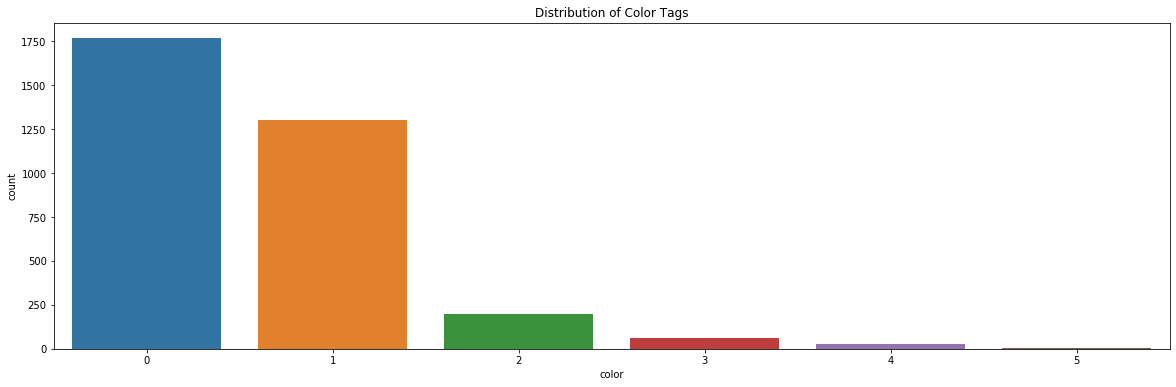

In [438]:
plt.figure(figsize=(20,6))
plt.title('Distribution of Color Tags')
sns.countplot(Bigraph.Data.color)
plt.show()

In [439]:
Bigraph.add_part_of_speech()

In [440]:
threshold = np.round(Bigraph.Data.color.value_counts().max()*0.2)
color_counts = Bigraph.Data.color.value_counts()
rare_color_counts = color_counts[color_counts<threshold]
common_color_counts = color_counts[color_counts>threshold]

query = ' '.join(f'color == {i} or' for i in rare_color_counts.index)
query = query[:-3]
rare_under_testing = Bigraph.Data.query(query)
rare_under_testing

query = ' '.join(f'color == {i} or' for i in common_color_counts.index)
query = query[:-3]
common_under_testing = Bigraph.Data.query(query)
common_under_testing

,color,word,pos
0,0,more,ADJ
1,1,the,DET
3,0,programming,NOUN
4,0,new,ADJ
5,1,c,X
...,...,...,...
3356,1,yau,PROPN
3357,1,yo,PROPN
3358,1,york,PROPN
3359,0,young,ADJ


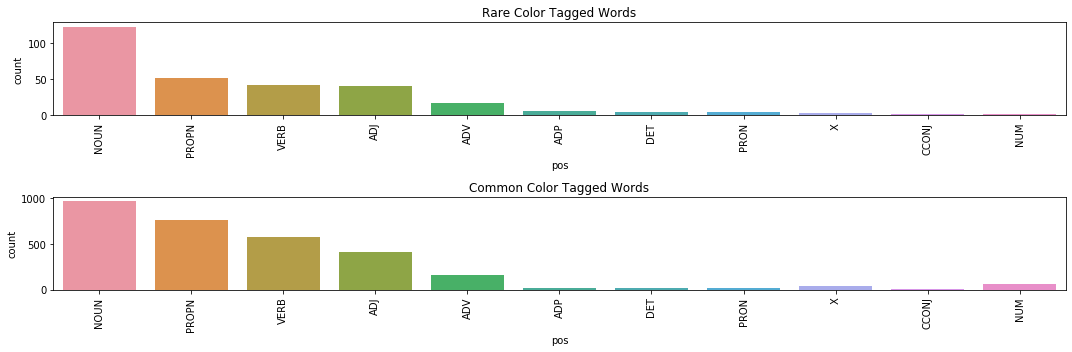

In [441]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.title('Rare Color Tagged Words')
ax=sns.countplot(rare_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.subplot(2,1,2)
plt.title('Common Color Tagged Words')
ax=sns.countplot(common_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.show()

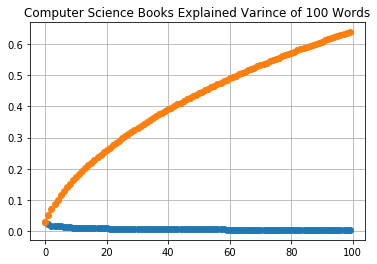

In [442]:
#Testing intext Variance

N = 100
CV=CountVectorizer()
pca = PCA(N)
pca.fit(CV.fit_transform(example_corpus).todense())

explained_var = pca.explained_variance_ratio_

plt.title(f'Computer Science Books Explained Varince of {N} Words')
plt.plot(range(N),explained_var,'o-')
plt.plot(range(N),np.cumsum(explained_var),'o-')
plt.grid()

In [443]:
#Vectorizing 
vectorized = []
for i in tqdm(example_corpus):
    vectorized.append(Bigraph.vectorize(i))


In [444]:
pad_size = example_corpus.apply(lambda x: len(x)).max()
vec_norm = []
for vec in vectorized:
    V = np.zeros(pad_size)-1
    V[:len(vec)] = vec
    vec_norm.append(np.array(V))
vec_norm = np.array(vec_norm)    

In [446]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=2,metric='cosine')

NN.fit(vec_norm)
distances, indices = NN.kneighbors(vec_norm)
NN

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=1.0)

In [447]:
#intersection between NN
for x,y in indices[:5]:
    INSC = set(example_corpus[x].split()) & set(example_corpus[y].split())
    print((INSC))

{'offers'}
{'more', 'the'}
{'in', 'more', 'design'}
{'more'}
{'more'}


In [448]:
#Cosine Distance
from scipy.spatial.distance import cosine
for x,y in indices[:5]:
    INSC = cosine(vec_norm[x,:],vec_norm[y,:])
    print((INSC))

0.04485524262670604
0.04382385801939337
0.07672298601898053
0.031067707611082684
0.041609874879008246


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Exploring Global Connection Between Chromatic Number and Differnt Dataset</h3>


In [157]:
from wordcloud import STOPWORDS
from string import punctuation
results = []

punctuation = punctuation + '“’‛‘”‹›»«–—'
example_corpus = pd.read_csv('LYRICS_DATASET.csv')['Lyrics'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)
results.append({'lyrics':Bigraph.Data})

example_corpus = pd.read_csv('Costumes_Amazon.csv')['text'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)

results.append({'amazon_reviews':Bigraph.Data})

example_corpus = pd.read_csv('prog_book.csv')['Description'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)
results.append({'prog_books':Bigraph.Data})


C:\Users\tomas\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [178]:
overlaping_words = set(list(results[0].values())[0]['word'])
for dic in results[1:]:
    overlaping_words = overlaping_words & set(list(dic.values())[0]['word'])
    
chrom_ds = pd.DataFrame(index = list(overlaping_words))
for dic in results:
    chrom_ds[list(dic.keys())[0]] = list(dic.values())[0].set_index('word').loc[overlaping_words]
    

In [212]:
chrom_ds.head(5)

,lyrics,amazon_reviews,prog_books
sounds,0,5,0
its,2,2,0
starting,0,0,0
care,3,9,0
book,1,3,2


In [213]:
same_chrom_num = chrom_ds.apply(lambda x: np.mean(x) == x[0] ,axis=1)

chrom_ds[same_chrom_num]

,lyrics,amazon_reviews,prog_books
starting,0,0,0
2010,0,0,0
started,0,0,0
beginning,0,0,0
criticism,0,0,0
...,...,...,...
u,1,1,1
brings,1,1,1
finish,0,0,0
question,0,0,0


In [196]:
import spacy as sp
_nlp = sp.load('en_core_web_sm')
parts_of_speech = chrom_ds.index.to_series().progress_apply(lambda _z: _nlp(str(_z))[0].pos_)

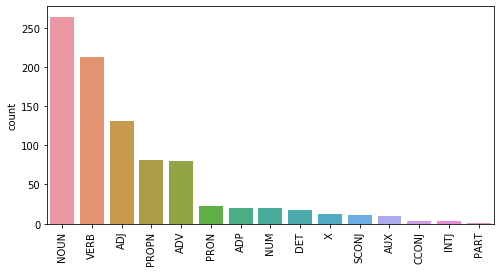

In [211]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x=parts_of_speech,order=parts_of_speech.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Paths</h3>


In [ ]:
'''

Question 1) Heaviest Path Between Two Nodes
Question 2) Generate A Random Chromatic Vector and Generate the heaviest walk between the vector members

'''

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Random Chromatic Walk</h3>


In [144]:
from string import punctuation
from wordcloud import STOPWORDS

example_corpus = pd.read_excel('creepypastas.xlsx',read_cols=['body']).body
example_corpus = example_corpus[example_corpus.notna()]
example_corpus = example_corpus.str.strip().apply(lambda x: [i for i in re.findall(r'[a-zA-Z ]+',x) if i not in STOPWORDS])
def join_with_space(ls):
    out = ''
    for i in ls:
        if i != ' ':
            out = out + i+' '
        else:
            out += i
    return out
    
example_corpus = example_corpus.apply(join_with_space)
example_corpus = ' '.join(example_corpus)
Bigraph = BiGramGraph([example_corpus],notebook=True)

In [147]:
Bigraph

Number of words included: 70585
Number of edges included: 1623734
Chromatic number: 64

In [148]:
class ChromaticRandomWalker:
    
    
    def __init__(self,Graph):
        self.Graph = Graph
        self.max_xi    = Graph.get_Xi()
        
    
    def __repr__(self):
        return self.Graph.__repr__()
        
    def generate_chromatic_vector(self,max_xi,size):
        chromatic_nums = list(range(max_xi))
        last_num = -1
        chrom_vec = []
        for i in range(size):
            index = np.floor((np.random.beta(1.5,1.5,1)*max_xi)[0])
            cur_choice = chromatic_nums[int(index)]
            while cur_choice == last_num:
                index = np.floor((np.random.beta(6,2,1)*max_xi)[0])
                cur_choice = chromatic_nums[int(index)]
            if cur_choice != last_num:
                last_num=cur_choice
                chrom_vec.append(cur_choice)
            else:
                continue
        self.Random_Chromatic_Vec = chrom_vec
    def calculate_path_weight(self,path):
        weight = 0
        start = path[0]
        for i in path[1:]:
            weight += self.Graph.Edges[(self.Graph.Edges['in'] == start)&(self.Graph.Edges.out == i)].weight.values[0]
            start =i
        return weight
    
    def generate(self,method='heaviest',vec_size = 5, depth=10):
        self.vec_size  = vec_size        
        self.generate_chromatic_vector(self.max_xi,self.vec_size)
        result = ' '
        first_word   = self.Graph.Data[self.Graph.Data.color==self.Random_Chromatic_Vec[0]].sample(1).word.values[0]
        for n in tqdm(self.Random_Chromatic_Vec[1:]):
            #Calculate Best Path
            paths = []
            targets = self.Graph.Data[self.Graph.Data.color==n]
            targets = targets.sample(depth if len(targets) >=depth else len(targets))
            for target in tqdm(targets.word,leave=False):
                gen = self.Graph.get_Shortest_Simple_Path(first_word,target)
                paths.append(next(gen))
            weights = np.array([self.calculate_path_weight(i) for i in paths])
            if method == 'heaviest':
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='lightest':
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            elif method =='density_max':
                weights = [calculate_path_density(self.Graph,i) for i in paths if i != np.ndarray ]
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='density_min':
                weights = [calculate_path_density(self.Graph,i) for i in paths if i != np.ndarray]
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            del weights
            result += ' '.join(best_walk[:-1])+' '

        return result


In [149]:
RCW = ChromaticRandomWalker(Bigraph)

In [153]:
RCW.generate(vec_size=10,method='density_min')

' mistake What kind you been procrastinators and running his gun fight here late was '

In [59]:
RCW.Random_Chromatic_Vec

[5, 3, 11, 4, 5, 8, 6, 7, 6, 5]

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Euler Cycles/Paths</h3>


In [122]:
unique_cycles = Bigraph.get_All_Unique_Cycles()

  0%|          | 0/11857 [00:00<?, ?it/s]

In [171]:
unique_cycles[9]

[('piece', 'everyone'),
 ('everyone', 'saw'),
 ('saw', 'stop'),
 ('stop', 'laughing'),
 ('laughing', 'feel'),
 ('feel', 'happy'),
 ('happy', 'very'),
 ('very', 'good'),
 ('good', 'ages'),
 ('ages', 'fun'),
 ('fun', 'piece')]

In [172]:
max(unique_cycles,key=lambda x: calculate_path_density(Bigraph,x))

[('very', 'good'),
 ('good', 'ages'),
 ('ages', 'fun'),
 ('fun', 'piece'),
 ('piece', 'everyone'),
 ('everyone', 'saw'),
 ('saw', 'stop'),
 ('stop', 'laughing'),
 ('laughing', 'feel'),
 ('feel', 'happy'),
 ('happy', 'very')]

In [154]:
Bigraph.Graph.out_degree('fore')

6

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Density of Nodes - Regions of High Density</h3>


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Design A Clustring Algorithms Based on The Graph</h3>


In [2]:
# Using some arbitrary alpha value we decide how far can we walk from a -
#spesific node in terms of the edge weights using dikstra for example